## Receiver Operating Characteristic (ROC) Curve and Precision / Recall (PR) curve

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preprocessing](#2.-Data-preprocessing)
3. [Model Training and Validation](#3.-Model-Training-and-Validation)
4. [What is ROC curve?](#4.-What-is-ROC-curve?)	
5. [What is PR curve?](#5.-What-is-PR-curve?)
6. [Summary](#6.-Summary)
7. [Reference](#7.-Reference)

## 1. Introduction 
Welcome!

We hope you have had a chance to go through the previous ROC and PR curve tutorial for structured data. In that tutorial, we touched upon a binary classification problem for structured data and plotted ROC and PR curves.

In this tutorial, we give an overview of how to plot ROC and PR curve for unstructured data and when to use each to interpret the prediction of probabilities for multiclass classification problems.


For ease of understanding, we use `CIFAR-10` dataset and generate the ROC curve and PR curve.

### Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running on Colab, make sure that your Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type), and make sure to click **Connect** on the top right-hand side of the screen before you start.<br>

In [ ]:
# for gpu set context as "!pip install nnabla-ext-cuda116"
# Preparation
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/roc_pr_curve

Before we go into a detailed explanation, here is a sneak peek into the steps involved in the process:

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/overview.PNG')
cv2_imshow(img)

Let's import dependencies.

In [1]:
import os, sys
import time
import nnabla as nn
from nnabla.ext_utils import get_extension_context
import nnabla.functions as F
import nnabla.parametric_functions as PF
import numpy as np
import functools
import matplotlib.pyplot as plt
import tarfile
from nnabla.logger import logger
from nnabla.utils.data_iterator import data_iterator
from nnabla.utils.data_source import DataSource
from nnabla.utils.data_source_loader import download
from utils import *
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

2022-12-13 14:37:51,508 [nnabla][INFO]: Initializing CPU extension...


## 2. Data preprocessing

Here, we define a data iterator for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) dataset. It'll download the dataset and pass the samples to the network during training.

In [2]:
class Cifar10DataSource(DataSource):
    '''
    Get data directly from cifar10 dataset from Internet(yann.lecun.com).
    '''

    def _get_data(self, position):
        image = self._images[self._indexes[position]]
        label = self._labels[self._indexes[position]]
        return (image, label)


    def __init__(self, train=True, shuffle=False, rng=None):
        super(Cifar10DataSource, self).__init__(shuffle=shuffle, rng=rng)
        self._train = train
        data_uri = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        logger.info('Getting labeled data from {}.'.format(data_uri))
        r = download(data_uri)  # file object returned
        with tarfile.open(fileobj=r, mode="r:gz") as fpin:
            # Training data
            if train:
                images = []
                labels = []
                for member in fpin.getmembers():
                    if "data_batch" not in member.name:
                        continue
                    fp = fpin.extractfile(member)
                    data = np.load(fp, encoding="bytes", allow_pickle=True)
                    images.append(data[b"data"])
                    labels.append(data[b"labels"])
                self._size = 50000
                self._images = np.concatenate(
                    images).reshape(self._size, 3, 32, 32)
                self._labels = np.concatenate(labels).reshape(-1, 1)
            # Validation data
            else:
                for member in fpin.getmembers():
                    if "test_batch" not in member.name:
                        continue
                    fp = fpin.extractfile(member)
                    data = np.load(fp, encoding="bytes", allow_pickle=True)
                    images = data[b"data"]
                    labels = data[b"labels"]
                self._size = 10000
                self._images = images.reshape(self._size, 3, 32, 32)
                self._labels = np.array(labels).reshape(-1, 1)
        r.close()
        logger.info('Getting labeled data from {}.'.format(data_uri))

        self._size = self._labels.size
        self._variables = ('x', 'y')
        if rng is None:
            rng = np.random.RandomState(313)
        self.rng = rng
        self.reset()

    def reset(self):
        if self._shuffle:
            self._indexes = self.rng.permutation(self._size)
        else:
            self._indexes = np.arange(self._size)
        super(Cifar10DataSource, self).reset()

    @property
    def images(self):
        """Get copy of whole data with a shape of (N, 1, H, W)."""
        return self._images.copy()

    @property
    def labels(self):
        """Get copy of whole label with a shape of (N, 1)."""
        return self._labels.copy()


def data_iterator_cifar10(batch_size,
                          train=True,
                          rng=None,
                          shuffle=True,
                          with_memory_cache=False,
                          with_file_cache=False):
    '''
    Provide DataIterator with :py:class:`Cifar10DataSource`
    with_memory_cache and with_file_cache option's default value is all False,
    because :py:class:`Cifar10DataSource` is able to store all data into memory.

    '''
    return data_iterator(Cifar10DataSource(train=train, shuffle=shuffle, rng=rng),
                         batch_size,
                         rng,
                         with_memory_cache,
                         with_file_cache)


In [3]:
def categorical_error(pred, label):
    pred_label = pred.argmax(1)
    return (pred_label != label.flat).mean()

## 3. Model Training and Validation

Now, let us define our neural network. In this example, we employ a slightly modified architecture based on ResNet. We are also performing data augmentation here.

In [4]:
def resnet23_prediction(image, test=False, ncls=10, nmaps=64, act=F.relu):
    """
    Construct ResNet 23
    """
    # Residual Unit
    def res_unit(x, scope_name, dn=False):
        C = x.shape[1]
        with nn.parameter_scope(scope_name):
            # Conv -> BN -> Nonlinear
            with nn.parameter_scope("conv1"):
                h = PF.convolution(x, C // 2, kernel=(1, 1), pad=(0, 0),
                                   with_bias=False)
                h = PF.batch_normalization(h, batch_stat=not test)
                h = act(h)
            # Conv -> BN -> Nonlinear
            with nn.parameter_scope("conv2"):
                h = PF.convolution(h, C // 2, kernel=(3, 3), pad=(1, 1),
                                   with_bias=False)
                h = PF.batch_normalization(h, batch_stat=not test)
                h = act(h)
            # Conv -> BN
            with nn.parameter_scope("conv3"):
                h = PF.convolution(h, C, kernel=(1, 1), pad=(0, 0),
                                   with_bias=False)
                h = PF.batch_normalization(h, batch_stat=not test)
            # Residual -> Nonlinear
            h = act(F.add2(h, x, inplace=True))
            # Maxpooling
            if dn:
                h = F.max_pooling(h, kernel=(2, 2), stride=(2, 2))
            return h
    # Conv -> BN -> Nonlinear
    with nn.parameter_scope("conv1"):
        # Preprocess
        if not test:
            image = F.image_augmentation(image, contrast=1.0,
                                         angle=0.25,
                                         flip_lr=True)
            image.need_grad = False
        h = PF.convolution(image, nmaps, kernel=(3, 3),
                           pad=(1, 1), with_bias=False)
        h = PF.batch_normalization(h, batch_stat=not test)
        h = act(h)

    h = res_unit(h, "conv2", False)    # -> 32x32
    h = res_unit(h, "conv3", True)     # -> 16x16
    h = res_unit(h, "conv4", False)    # -> 16x16
    h = res_unit(h, "conv5", True)     # -> 8x8
    h = res_unit(h, "conv6", False)    # -> 8x8
    h = res_unit(h, "conv7", True)     # -> 4x4
    h = res_unit(h, "conv8", False)    # -> 4x4
    h = F.average_pooling(h, kernel=(4, 4))  # -> 1x1
    pred = PF.affine(h, ncls)

    return pred

Loss function is defined here. It is the mean of softmax cross entropy, computed from the predictions and the target labels.

In [5]:
def loss_function(pred, label):
    loss = F.mean(F.softmax_cross_entropy(pred, label))
    return loss

Let's define hyper-parameters for training.

In [6]:
batch_size = 64
bs_valid = 64 #batch size for validation
extension_module = 'cpu' ###"cudnn" for GPU
ctx = get_extension_context(
    extension_module)
nn.set_default_context(ctx)
prediction = functools.partial(
    resnet23_prediction, ncls=10, nmaps=64, act=F.relu)

Let's create the training and validation graphs. Then, we define data iterator variables separately for training and validation, using the data iterator. 

Note the labels are not provided for validation and the second argument is different for each variable, depending on whether it is for training or validation.

In [7]:
# Create training graphs
test = False
image_train = nn.Variable((batch_size, 3, 32, 32))
label_train = nn.Variable((batch_size, 1))
pred_train = prediction(image_train, test)
loss_train = loss_function(pred_train, label_train)
input_image_train = {"image": image_train, "label": label_train}

# Create validation graph
test = True
image_valid = nn.Variable((bs_valid, 3, 32, 32))
label_valid = nn.Variable((batch_size, 1))
pred_valid = prediction(image_valid, test)
input_image_valid = {"image": image_valid, "label": label_valid}

# Data Iterator
tdata = data_iterator_cifar10(batch_size, True)
vdata = data_iterator_cifar10(batch_size, False)

2022-12-13 14:37:55,853 [nnabla][INFO]: DataSource with shuffle(True)
2022-12-13 14:37:55,853 [nnabla][INFO]: Getting labeled data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.
2022-12-13 14:37:55,869 [nnabla][INFO]: > C:\Users\7000024053/nnabla_data\cifar-10-python.tar.gz already exists.
2022-12-13 14:37:55,872 [nnabla][INFO]: > If you have any issue when using this file, 
2022-12-13 14:37:55,873 [nnabla][INFO]: > manually remove the file and try download again.
2022-12-13 14:38:01,011 [nnabla][INFO]: Getting labeled data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.
2022-12-13 14:38:01,039 [nnabla][INFO]: Using DataIterator
2022-12-13 14:38:01,045 [nnabla][INFO]: DataSource with shuffle(True)
2022-12-13 14:38:01,047 [nnabla][INFO]: Getting labeled data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.
2022-12-13 14:38:01,050 [nnabla][INFO]: > C:\Users\7000024053/nnabla_data\cifar-10-python.tar.gz already exists.
2022-12-13 14:38:01,054 [nna

We have trained the Classifier for 40000 iterations and saved the model. If you want to train the Classifier from scratch please refer to our GitHub page and follow the steps.

Now let us get the pre-trained weights for the Classifier and load the model. Then we shall plot the ROC & PR curves.

In [8]:
# download the pre-trained weights
# !wget https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/roc_and_pr_curve/best_model.h5
# !wget https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/ml_plugins/params_40000.h5
nn.load_parameters("best_model.h5")

In [9]:
val_iter = 10
target_variable = []
output_variable = []
#Validation
ve = 0.
for j in range(val_iter):
    image, label = vdata.next()
    input_image_valid["image"].d = image
    input_image_valid["label"].d = label
    pred_prob = F.softmax(pred_valid)
    pred_prob.forward(clear_buffer=True)
    target_variable.extend(label)
    output_variable.append(pred_prob.d)
    ve += categorical_error(pred_valid.d, label)
ve /= val_iter

In [10]:
target_label = label_binarize(target_variable, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
predicted_label = np.concatenate(output_variable)

## 4. What is ROC curve?

We could understand the information about False Positive Rate and True Positive Rate with ROC curve. Area under the ROC curve give is also a metric (AUC); the larger, the better.

$$True Positive Rate = \displaystyle\frac{\#\{\text{True Positives}\}}{\#\{\text{True Positives}\} + \#\{\text{False Negatives}\}}$$ <br>

$$False Positive Rate = \displaystyle\frac{\#\{\text{False Positives}\}}{\#\{\text{False Positives}\} + \#\{\text{True Negatives}\}}$$ <br>

Note that default ROC curve is intended for classification problem with two classes. When there are more than two classes, ROC curves must be plotted with respect to each class taking the rest of the combination of other classes as 'False class'.

In [11]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
n_classes = 10

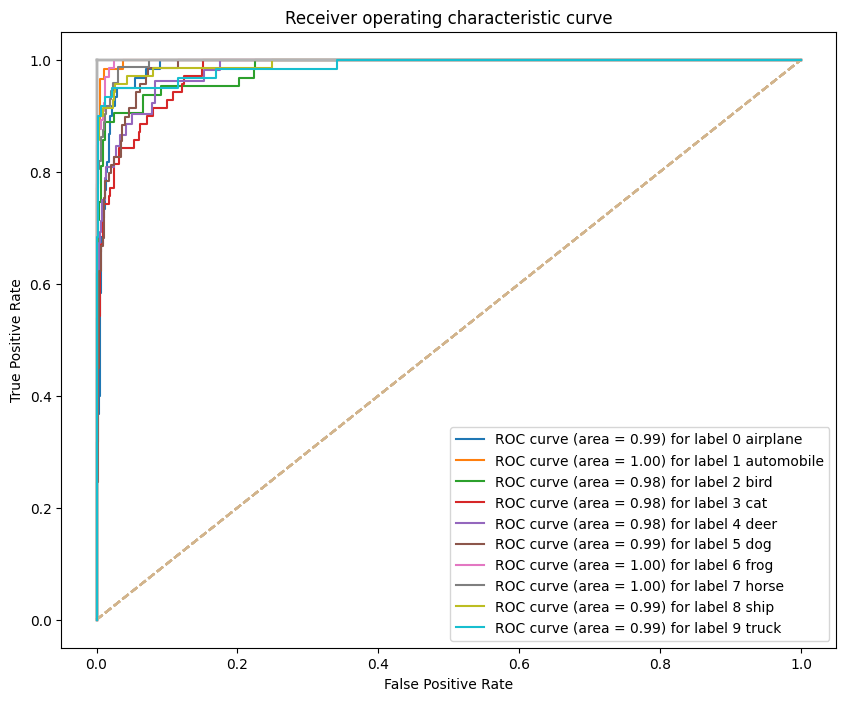

In [12]:
# Compute ROC curve and ROC area for each class
get_roc_curve_multiclass(target_label, predicted_label, n_classes, labels)

ROC-AUC curve is plotted between the True positive rate and the false positive rate. True positive rate is put on the y-axis whereas the false positive rate is put on the x-axis.

Here we plotted ROC curve for one vs the rest of the labels. In CIFAR-10 there are 10 target variables. An ROC curve for each target variable vs the rest of the variables is plotted and AUC is calculated for each class.

## 5. What is PR curve?

When trying classification models in machine learning, two metrics often used to assess the quality of the model are precision and recall. Precision-recal curve shows the tradeoff between precision and recalls for different thresholds in a given model. The area under the PR curve give is also a metric (AUC); higher the area, more desirable is the model.





**Precision:** Correct positive predictions relative to total positive predictions





$$Precision = \displaystyle\frac{\#\{\text{True Positives}\}}{\#\{\text{True Positives}\} + \#\{\text{False Positives}\}}$$ <br>





**Recall:** Correct positive predictions relative to total actual positives





$$Recall = \displaystyle\frac{\#\{\text{True Positives}\}}{\#\{\text{True Positives}\} + \#\{\text{False Negatives}\}}$$<br>

Let's plot the PR curve for each target variable vs the rest of the variables and calculate AUC for each.

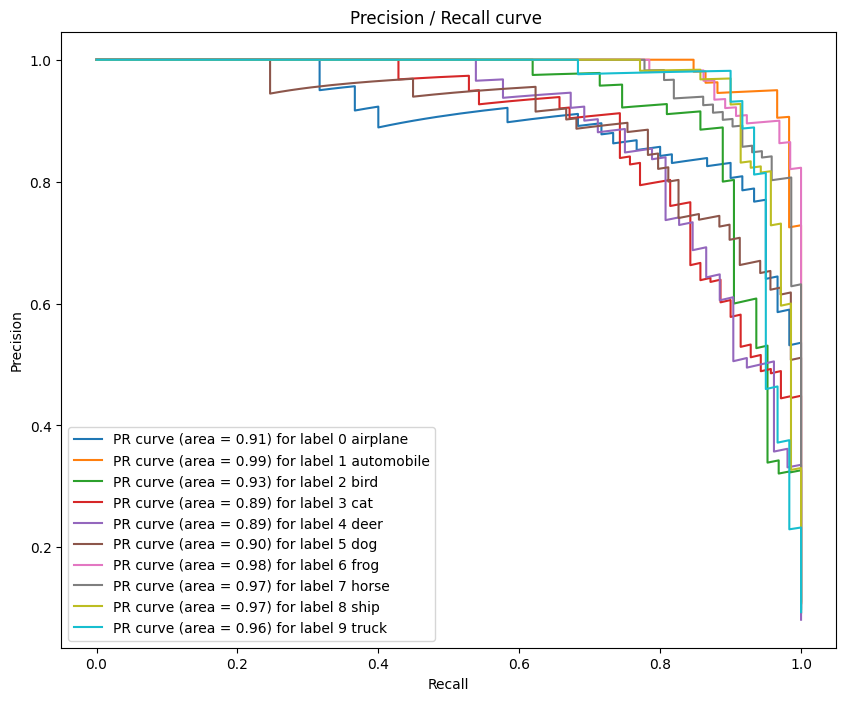

In [13]:
# Compute PR curve and PR area for each class
get_pr_curve_multiclass(target_label, predicted_label, n_classes, labels)

The x-axis shows the Recall and the y-axis shows the Precision for various thresholds.

Notice that as recall increases, the precision decreases. This represents the tradeoff between the two metrics. On increasing the recall of the model, the precision decreases and vice versa.


**Both ROC-AUC & PR curves used for,**

* To explain model goodness and fit.
* To identify the correct threshold to map probability values to the actual class (0/1).


## 6. Summary
In this tutorial, we have shown the ROC and PR curves for unstructured data.

**When to use ROC / PR curve:**
1. When there is imbalance in class distribution in the dataset, use PR curve to explain the model goodness of fit and for threshold detection.
2. ROC-AUC curve is used when data set is balanced with respect to target class distribution.

## 7. Reference
[1] [Krizhevsky, Alex, and Geoffrey Hinton. "Learning multiple layers of features from tiny images."](https://www.cs.toronto.edu/~kriz/cifar.html) (2009)

[2] He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image recognition." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 770-778. 2016.

[3] He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Identity mappings in deep residual networks." In European conference on computer vision, pp. 630-645. Springer, Cham, 2016.
